# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
import seaborn as sns
import matplotlib.pyplot as plt
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"

# read the dataset
df = pd.read_csv(dataset_path)
 
# make exact copy of df to be used later
df_copy = df.copy()

# replace "?" with NaN, and "?|?" with NaN
df = df.replace('?', np.nan).replace("?|?", np.nan)

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,NaN,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [5]:
df.shape

(143424, 26)

In [6]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
primary_diagnosis_code      object
other_diagnosis_codes       object
number_outpatient            int64
number_inpatient             int64
number_emergency             int64
num_lab_procedures           int64
number_diagnoses             int64
num_medications              int64
num_procedures               int64
ndc_code                    object
max_glu_serum               object
A1Cresult                   object
change                      object
readmitted                  object
dtype: object

In [7]:
# Find the Number of Unique Encounters
df['encounter_id'].nunique() 

101766

In [8]:
# Find the total number of rows of df
len(df)

143424

__Student Response:__ Since the number of unique encounters is 101766 < 143424, which is the total number of rows of df, then the dataset must be at the __Line Level__.

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

### a. Field(s) with high amount of missing/zero values

In [9]:
# Function to find missing and zero values 
def check_null_values(df):
    null_df = pd.DataFrame({'columns': df.columns, 
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                           'percent_zero': df.isin([0]).sum() * 100 / len(df)
                           } )
    return null_df 

In [10]:
# Let's count the amount of null values in each column
df.isnull().sum()

encounter_id                     0
patient_nbr                      0
race                          3309
gender                           0
age                              0
weight                      139122
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code                   54190
medical_specialty            69463
primary_diagnosis_code          33
other_diagnosis_codes          340
number_outpatient                0
number_inpatient                 0
number_emergency                 0
num_lab_procedures               0
number_diagnoses                 0
num_medications                  0
num_procedures                   0
ndc_code                     23462
max_glu_serum                    0
A1Cresult                        0
change                           0
readmitted                       0
dtype: int64

In [11]:
# Calculate missing and zero values and record them in null_df
null_df = check_null_values(df)
null_df

,columns,percent_null,percent_zero
encounter_id,encounter_id,0.000000,0.000000
patient_nbr,patient_nbr,0.000000,0.000000
race,race,2.307145,0.000000
gender,gender,0.000000,0.000000
age,age,0.000000,0.000000
weight,weight,97.000502,0.000000
admission_type_id,admission_type_id,0.000000,0.000000
discharge_disposition_id,discharge_disposition_id,0.000000,0.000000
admission_source_id,admission_source_id,0.000000,0.000000
time_in_hospital,time_in_hospital,0.000000,0.000000


We see that the fields with the highest missing values are __weight, payer_code, medical_specialty,__ and __ndc_code__. On the other hand fields with the hightest zero values are __number_outpatient, number_inpatient, number_emergency,__ and __number_precedures__.

### b. Frequency histogram for each numerical field

In [12]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

In [13]:
# Here we assume age and weight is a numerical field although they were turned into an object
# by using bins

numerical_fields = ["time_in_hospital", "number_outpatient", "number_inpatient", "number_emergency", 
                            'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']

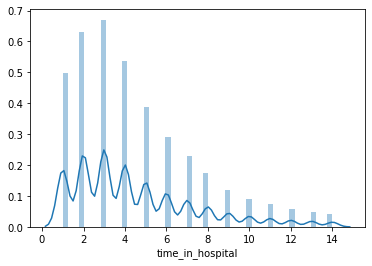

In [14]:
sns.distplot(df['time_in_hospital'])

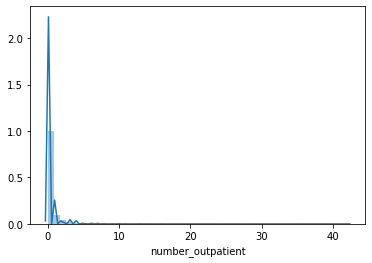

In [15]:
sns.distplot(df['number_outpatient'])

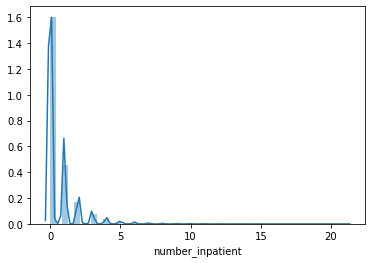

In [16]:
sns.distplot(df['number_inpatient'])

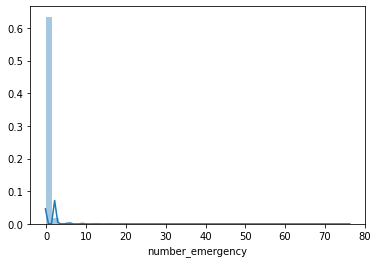

In [17]:
sns.distplot(df['number_emergency'])

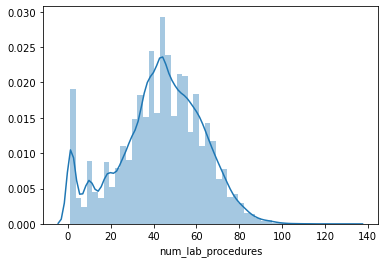

In [18]:
# Since the range is large, we use distplot instead of countplot

sns.distplot(df['num_lab_procedures'])

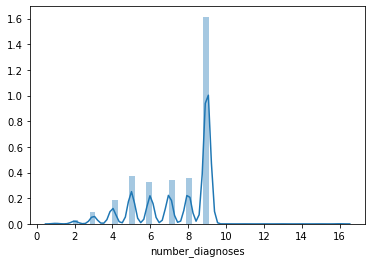

In [19]:
sns.distplot(df['number_diagnoses'])

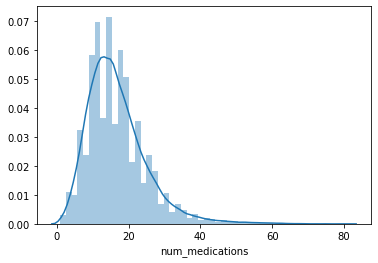

In [20]:
# Since the range is large, we use distplot instead of countplot

sns.distplot(df['num_medications'])

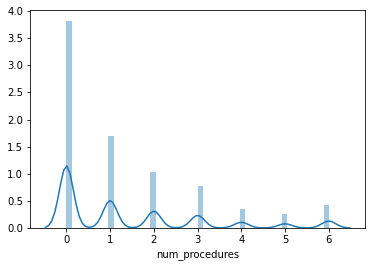

In [21]:
sns.distplot(df['num_procedures'])

From the density plot, we see that __num_lab_procedures__ and __num_medications__ are the numberical features which somewhat has gausian or normal distribution.

### c. Field(s) have high cardinality 

In [22]:
# Here we include age and gender since they are divided into bins

categorical_fields = ['age', 'weight', 'race', 'gender', 'admission_type_id', 'discharge_disposition_id', 
                      'admission_source_id', 'payer_code', 'medical_specialty',
                      'primary_diagnosis_code', 'other_diagnosis_codes', 'ndc_code',
                      'max_glu_serum', 'A1Cresult', 'change', 'readmitted']

In [23]:
# Function to count unique value for each column
def count_unique_values(df, cat_col_list):
    cat_df = df[cat_col_list]
    val_df = pd.DataFrame({'columns': cat_df.columns, 
                       'cardinality': cat_df.nunique() } )
    return val_df

In [24]:
# count unique value for each column and record them in val_df
val_df = count_unique_values(df, categorical_fields) 
val_df

,columns,cardinality
age,age,10
weight,weight,9
race,race,5
gender,gender,3
admission_type_id,admission_type_id,8
discharge_disposition_id,discharge_disposition_id,26
admission_source_id,admission_source_id,17
payer_code,payer_code,17
medical_specialty,medical_specialty,72
primary_diagnosis_code,primary_diagnosis_code,716


The categorical features which has extremely high cardinality (>70) are __medical_specialty, primary_diagnosis_code, other_diagnosis_code,__ and __ndc_code__. These features have high cardinality since their values represent codes which are plenty in medical field. 

### d. Gender distribution

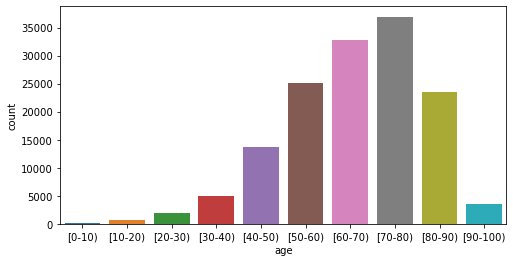

In [25]:
plt.figure(figsize=(8,4))
sns.countplot(data = df, x = 'age')

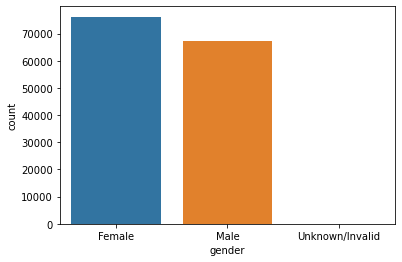

In [26]:
sns.countplot(x="gender", data=df)

In [27]:
# See the percentage of Unknown/Invalid gender
len(df[df["gender"] == "Unknown/Invalid"])/len(df["gender"])*100

0.0034861668897813477

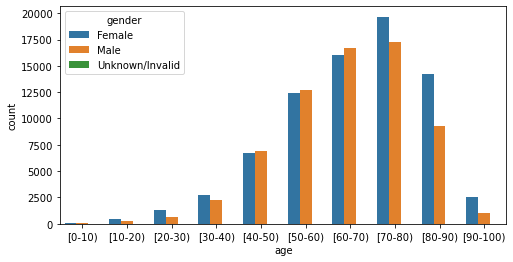

In [28]:
plt.figure(figsize=(8,4))
sns.countplot(x="age", hue="gender", data=df)

The gender distribution seems to be uniform with a slight preference toward Female.

**Student Response**: 

    a. Fields with the highest missing values are __weight, payer_code, medical_specialty, and ndc_code. On the other hand fields with the hightest zero values are number_outpatient, number_inpatient, number_emergency, number_precedures.
    b. It seems that 'num_lab_procedures' and 'num_medications' are the numberical features which has gausian or normal distribution.
    c. The categorical features which has extremely high cardinality (>70) are medical_specialty, primary_diagnosis_code, other_diagnosis_code, and ndc_code. These features have high cardinality since their values represent codes which are plenty in medical field. 
    d. The age distribution is left skewed with the highest peak at age 70 to 80. On the other hand, the gender distribution seems to be uniform with a slight preference toward Female. If we plot both age and gender distribution together, we see that there is a little preference toward male age age 40 to 50, 50 to 60, and 60 to 70. 

### Additional EDA 

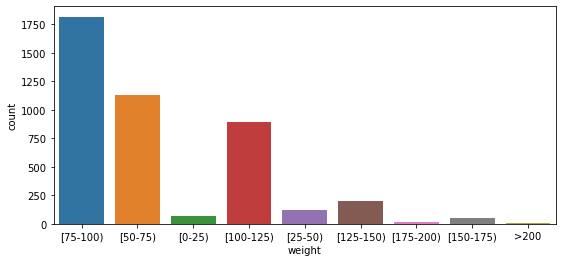

In [29]:
plt.figure(figsize=(9,4))
sns.countplot(data = df, x = 'weight')

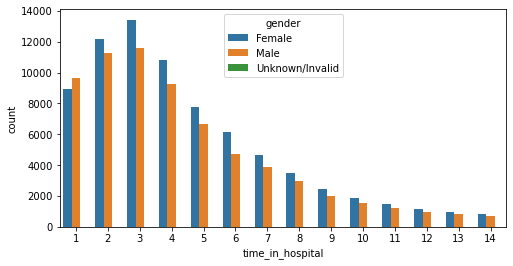

In [30]:
plt.figure(figsize=(8,4))
sns.countplot(x="time_in_hospital", hue="gender", data=df)

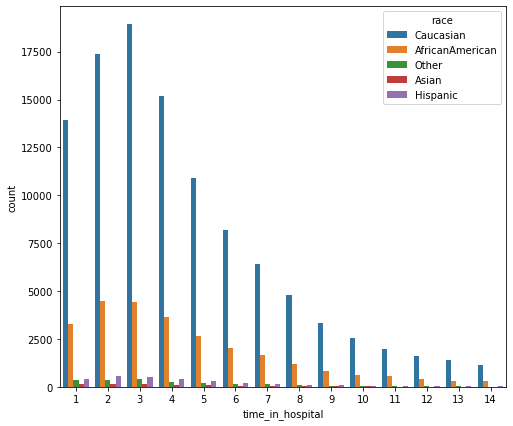

In [31]:
plt.figure(figsize=(8,7))
sns.countplot(x="time_in_hospital", hue="race", data=df)

We see the majority of the patients in the dataset is Caucasian, followed by African American, Hispanic, Other, and Asian.

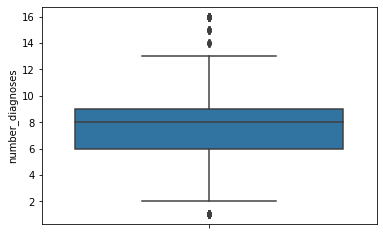

In [32]:
sns.boxplot(y = df['number_diagnoses'])

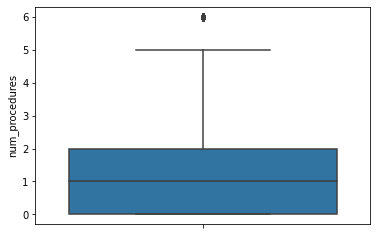

In [33]:
sns.boxplot(y = df['num_procedures'])

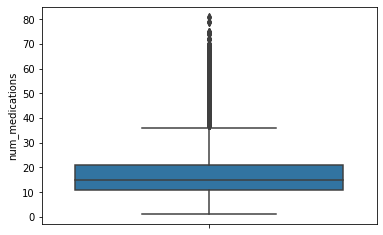

In [34]:
sns.boxplot(y = df['num_medications'])

We see that there are a lot of outliers in num_medication.

In [35]:
######NOTE: The visualization will only display in Chrome browser. ########
#full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
#tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [36]:
# Get the original df back
df = df_copy.copy()

#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [37]:
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


From above we see that multiple NDC_Code has the same Non-propriatary Name or generic drug name.

In [38]:
ndc_code_df.dtypes

NDC_Code                object
Proprietary Name        object
Non-proprietary Name    object
Dosage Form             object
Route Name              object
Company Name            object
Product Type            object
dtype: object

In [39]:
ndc_code_df.NDC_Code.nunique()

267

In [40]:
len(ndc_code_df)

269

In [41]:
# Find the number of null value in ndc_code_df
ndc_code_df.isnull().sum()

NDC_Code                0
Proprietary Name        0
Non-proprietary Name    0
Dosage Form             2
Route Name              5
Company Name            2
Product Type            2
dtype: int64

In [42]:
# Find duplicate of NDC_Code in ndc_code_df
find_duplicate=ndc_code_df.NDC_Code.value_counts()
find_duplicate[find_duplicate > 1]

0781-5634    2
0781-5635    2
Name: NDC_Code, dtype: int64

In [43]:
# Find the index of duplicate '0781-5634'
ndc_code_df.index[ndc_code_df['NDC_Code'] == '0781-5634']

Int64Index([150, 263], dtype='int64')

In [44]:
# Find the index of duplicate '0781-5635'
ndc_code_df.index[ndc_code_df['NDC_Code'] == '0781-5635']

Int64Index([151, 264], dtype='int64')

In [45]:
# Drop duplicates
ndc_code_df.drop([150 , 151], inplace=True)

In [46]:
len(ndc_code_df)

267

In [47]:
from student_utils import reduce_dimension_ndc

In [48]:
# Create reduce_dim_df from df which map the ndc_code in df to Non-proprietary Name in ndc_code_df
# We change the Non-proprietary Name to generic_drug_name, then delete the column ndc_code

reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,None,None,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,None,None,Ch,>30,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,None,None,No,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,None,None,Ch,NO,Glipizide


In [49]:
# Check the patient number of the merged dataset
reduce_dim_df['patient_nbr'].nunique()

71518

In [50]:
# Check the shape of the merged dataset
reduce_dim_df.shape

(143424, 26)

In [51]:
# Make sure the lenght of reduce_dim_df is equal to len of df
len(reduce_dim_df)==len(df)

True

In [52]:
# Find the number of unique 'generic_drug_name' of reduce_dim_df
reduce_dim_df['generic_drug_name'].nunique()

22

In [53]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()
print("Successfully Reduce Dimensionality of the NDC Code Feature")

Successfully Reduce Dimensionality of the NDC Code Feature


## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [54]:
from student_utils import select_first_encounter

# Create first_encounter_df
first_encounter_df = select_first_encounter(reduce_dim_df)

In [55]:
first_encounter_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
12,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,None,None,Ch,NO,Insulin Human
11,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,None,None,Ch,NO,Glipizide
14,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,None,None,Ch,NO,Human Insulin
13,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,None,None,Ch,NO,Rosiglitazone Maleate
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,None,None,Ch,NO,Glipizide


In [56]:
first_encounter_df.shape

(101754, 26)

In [57]:
print("Total number of unique patien_nbr in reduce_dim_df = ",reduce_dim_df['patient_nbr'].nunique())

Total number of unique patien_nbr in reduce_dim_df =  71518


In [58]:
print("Total number of unique encounter_id = ", len(first_encounter_df['encounter_id'].unique()))
print("Total number of unique encounter patients = ", len(first_encounter_df['patient_nbr'].unique()))

Total number of unique encounter_id =  71518
Total number of unique encounter patients =  71518


In [59]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [60]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]

In [61]:
from utils import aggregate_dataset
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [62]:
agg_drug_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,None,None,Ch,NO,"[Insulin Human, Glipizide]",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,None,None,Ch,NO,"[Human Insulin, Rosiglitazone Maleate]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,None,None,Ch,NO,"[Glipizide, Human Insulin]",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,None,None,No,>30,[Human Insulin],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,None,None,No,>30,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
ndc_col_list

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Miglitol',
 'Nateglinide',
 'Pioglitazole_And_Metformin_Hydrochloride',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide']

In [64]:
len(ndc_col_list)

21

In [65]:
first_encounter_df.generic_drug_name.unique()

array(['Insulin Human', 'Glipizide', 'Human Insulin',
       'Rosiglitazone Maleate', 'Glyburide', 'Repaglinide',
       'Metformin Hydrochloride', 'Glimepiride', nan, 'Acarbose',
       'Tolbutamide', 'Tolazamide', 'Pioglitazone', 'Metformin Hcl',
       'Pioglitazone Hydrochloride And Glimepiride',
       'Glyburide-metformin Hydrochloride', 'Nateglinide',
       'Glyburide And Metformin Hydrochloride', 'Miglitol',
       'Glipizide And Metformin Hydrochloride',
       'Glipizide And Metformin Hcl',
       'Pioglitazole And Metformin Hydrochloride'], dtype=object)

In [66]:
first_encounter_df.generic_drug_name.nunique()

21

In [67]:
agg_drug_df.shape

(71518, 47)

In [68]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()
print("Succesfully Aggregate Dataset to Right Level for Modeling")

Succesfully Aggregate Dataset to Right Level for Modeling


In [69]:
agg_drug_df=agg_drug_df.replace('?',np.nan).replace('?|?',np.nan)
agg_drug_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),NaN,2,1,4,13,NaN,NaN,398,427|38,0,0,0,68,8,28,2,None,None,Ch,NO,"[Insulin Human, Glipizide]",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15738,63555939,Caucasian,Female,[90-100),NaN,3,3,4,12,NaN,InternalMedicine,434,198|486,0,0,0,33,8,18,3,None,None,Ch,NO,"[Human Insulin, Rosiglitazone Maleate]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,None,None,Ch,NO,"[Glipizide, Human Insulin]",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28236,89869032,AfricanAmerican,Female,[40-50),NaN,1,1,7,9,NaN,NaN,250.7,403|996,0,0,0,47,9,17,2,None,None,No,>30,[Human Insulin],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35754,82637451,Caucasian,Male,[50-60),NaN,2,1,2,3,NaN,NaN,414,411|250,0,0,0,31,9,16,6,None,None,No,>30,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

In [70]:
agg_drug_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted',
       'generic_drug_name_array', 'Acarbose', 'Glimepiride', 'Glipizide',
       'Glipizide_And_Metformin_Hcl', 'Glipizide_And_Metformin_Hydrochloride',
       'Glyburide', 'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazole_And_Metformin_Hydrochloride', 'Pioglitazone',
       'Pioglitazone_Hydrochloride_And_Glimepiride', 'Repaglinide',
       '

In [71]:
(agg_drug_df.isnull().sum()/len(agg_drug_df))*100

encounter_id                                   0.000000
patient_nbr                                    0.000000
race                                           2.723790
gender                                         0.000000
age                                            0.000000
weight                                        96.010794
admission_type_id                              0.000000
discharge_disposition_id                       0.000000
admission_source_id                            0.000000
time_in_hospital                               0.000000
payer_code                                    43.405856
medical_specialty                             48.207444
primary_diagnosis_code                         0.015381
other_diagnosis_codes                          0.341173
number_outpatient                              0.000000
number_inpatient                               0.000000
number_emergency                               0.000000
num_lab_procedures                             0

__Student response:__ 

From the percentage of null values in each column, we see __weight, payer_code, and medical_specialty__ have extremely high null values. Therefore, we won't include them in our model.

For the numerical fields, we will only include __num_lab_procedures__ and __num_medications__ since from our previous EDA, we found that they are the ones which have gausian or normal distribution.

Let's see the plot of some categorical fields to see whether we should include them in our model.

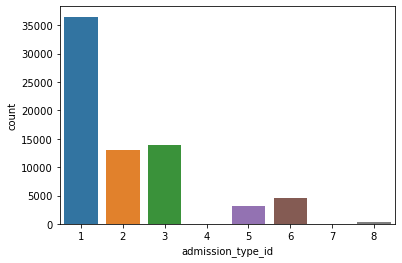

In [72]:
sns.countplot(agg_drug_df["admission_type_id"])

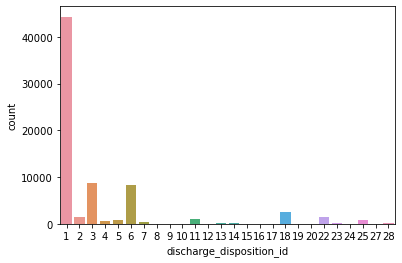

In [73]:
sns.countplot(agg_drug_df['discharge_disposition_id'])

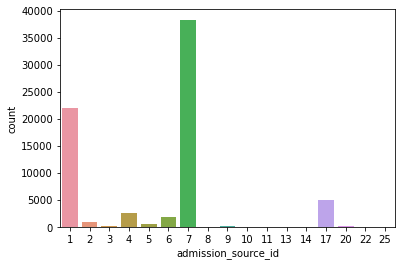

In [74]:
sns.countplot(agg_drug_df["admission_source_id"])

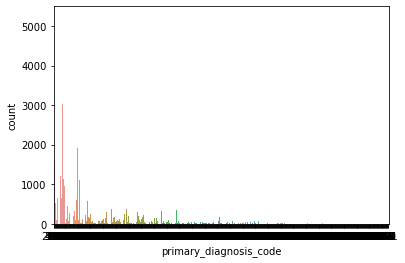

In [75]:
sns.countplot(agg_drug_df["primary_diagnosis_code"])

In [76]:
# Find the cardinality of other_diagnosis_codes
agg_drug_df["other_diagnosis_codes"].nunique()

15755

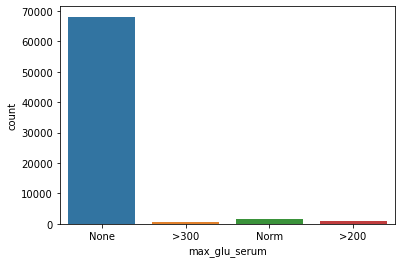

In [77]:
sns.countplot(agg_drug_df["max_glu_serum"])

We will not use __admission_type_id, discharge_disposition_id, admission_source_id, primary_diagnosis_code__ and __max_glu_serum__ since from the above distribution plots, we see that they are highly skewed. We also won't include __other_diagnosis_codes__ since it has extremely high cardinality (15755) and it doesn't seems to add value to our model.

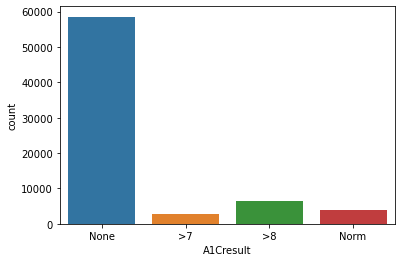

In [78]:
sns.countplot(agg_drug_df['A1Cresult'])

We will use __A1Cresult__ even though the distribution plot is skewed since it is important in the diagnoses of the diabetes

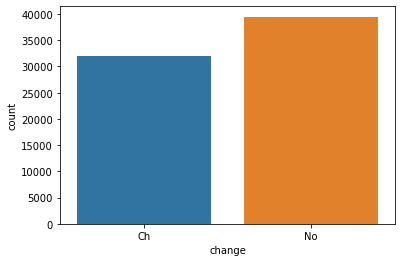

In [79]:
sns.countplot(agg_drug_df['change'])

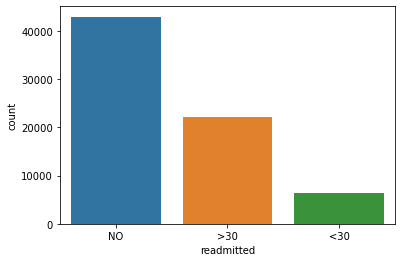

In [80]:
sns.countplot(agg_drug_df['readmitted'])

We will ignore __change__ and __readmitted__ since they don't add value to our model.

In [81]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = ["primary_diagnosis_code", "readmitted", "A1Cresult"] + required_demo_col_list + ndc_col_list
student_numerical_col_list = ["num_lab_procedures", "num_medications"]
PREDICTOR_FIELD = 'time_in_hospital'

In [82]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [83]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

In [84]:
selected_features_df.head() 

,patient_nbr,time_in_hospital,primary_diagnosis_code,readmitted,A1Cresult,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,num_lab_procedures,num_medications
0,48330783,13,398,NO,None,Caucasian,Female,[80-90),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,28
1,63555939,12,434,NO,None,Caucasian,Female,[90-100),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33,18
2,42519267,1,197,NO,None,Caucasian,Male,[40-50),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51,8
3,89869032,9,250.7,>30,None,AfricanAmerican,Female,[40-50),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47,17
4,82637451,3,414,>30,None,Caucasian,Male,[50-60),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,16


In [85]:
selected_features_df.shape

(71518, 31)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [86]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [87]:
processed_df.head()

,patient_nbr,time_in_hospital,primary_diagnosis_code,readmitted,A1Cresult,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,num_lab_procedures,num_medications
0,48330783,13.0,398,NO,None,Caucasian,Female,[80-90),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,28
1,63555939,12.0,434,NO,None,Caucasian,Female,[90-100),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33,18
2,42519267,1.0,197,NO,None,Caucasian,Male,[40-50),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51,8
3,89869032,9.0,250.7,>30,None,AfricanAmerican,Female,[40-50),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47,17
4,82637451,3.0,414,>30,None,Caucasian,Male,[50-60),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,16


In [88]:
processed_df.shape

(71518, 31)

In [89]:
# Check the percentage of null values for each column in processed_df
processed_df.isnull().sum()/len(processed_df)*100

patient_nbr                                   0.0
time_in_hospital                              0.0
primary_diagnosis_code                        0.0
readmitted                                    0.0
A1Cresult                                     0.0
race                                          0.0
gender                                        0.0
age                                           0.0
Acarbose                                      0.0
Glimepiride                                   0.0
Glipizide                                     0.0
Glipizide_And_Metformin_Hcl                   0.0
Glipizide_And_Metformin_Hydrochloride         0.0
Glyburide                                     0.0
Glyburide_And_Metformin_Hydrochloride         0.0
Glyburide-metformin_Hydrochloride             0.0
Human_Insulin                                 0.0
Insulin_Human                                 0.0
Metformin_Hcl                                 0.0
Metformin_Hydrochloride                       0.0


## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [90]:
from student_utils import patient_dataset_splitter

# Split the processed_df into 80% train set and 20% test set
d_train, d_test = patient_dataset_splitter(processed_df, 'patient_nbr', 0.2)

print("Temporary train shape: ",d_train.shape)
print("Final test shape: ",d_test.shape )

Temporary train shape:  (57214, 31)
Final test shape:  (14304, 31)


In [91]:
# Split the d_train into 75% train set and 25% val set. By doing so, we will get 60%/20%/20% of
# d_train, d_test, d_val from processed_df
d_train, d_val = patient_dataset_splitter(d_train, 'patient_nbr', 0.25)

print("Final train shape: ",d_train.shape)
print("Final validation shape: ",d_val.shape )

Final train shape:  (42910, 31)
Final validation shape:  (14304, 31)


In [92]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [93]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     10717
2.0     12397
3.0     12701
4.0      9567
5.0      6839
6.0      5171
7.0      3999
8.0      2919
9.0      1990
10.0     1558
11.0     1241
12.0      955
13.0      795
14.0      669
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


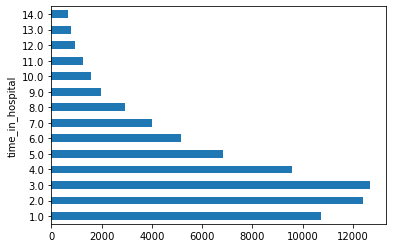

In [94]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6403
2.0     7437
3.0     7547
4.0     5812
5.0     4068
6.0     3131
7.0     2417
8.0     1715
9.0     1232
10.0     958
11.0     748
12.0     559
13.0     487
14.0     396
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


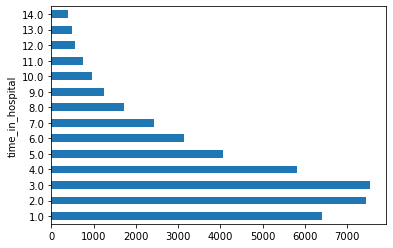

In [95]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2146
2.0     2409
3.0     2647
4.0     1855
5.0     1417
6.0      987
7.0      787
8.0      635
9.0      392
10.0     286
11.0     273
12.0     207
13.0     127
14.0     136
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


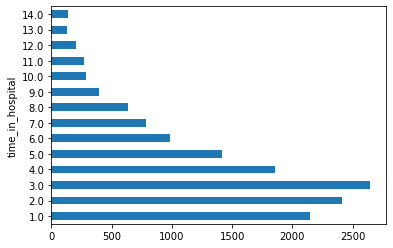

In [96]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

time_in_hospital
1.0     2168
2.0     2551
3.0     2507
4.0     1900
5.0     1354
6.0     1053
7.0      795
8.0      569
9.0      366
10.0     314
11.0     220
12.0     189
13.0     181
14.0     137
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


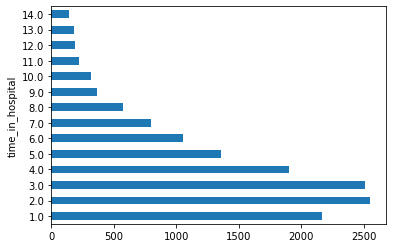

In [97]:
show_group_stats_viz(d_val, PREDICTOR_FIELD)

From the above distributution of the label 'time_in_hospital', we see that the histogram distribution shapes are similar across partitions.

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

### Gender Group Analysis

gender
Female             38025
Male               33490
Unknown/Invalid        3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


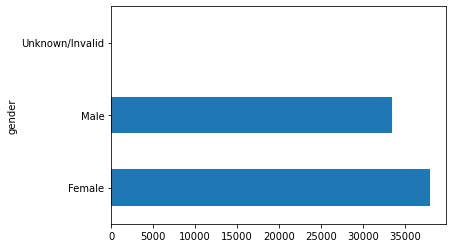

In [98]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             22762
Male               20145
Unknown/Invalid        3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


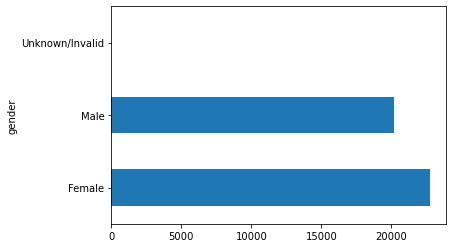

In [99]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    7672
Male      6632
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


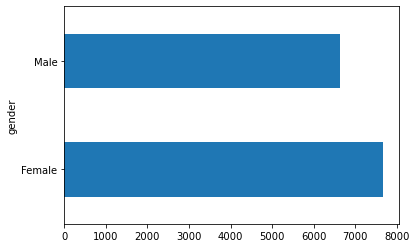

In [100]:
# Test partition
show_group_stats_viz(d_test, 'gender')

gender
Female    7591
Male      6713
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


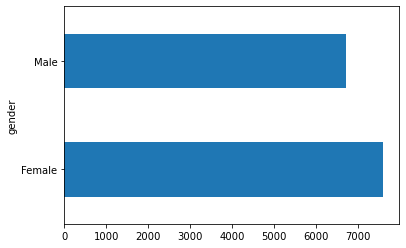

In [101]:
show_group_stats_viz(d_val, 'gender')

### Race Group Analysis

race
AfricanAmerican    12887
Asian                497
Caucasian          53491
Hispanic            1517
Other               1178
nan                 1948
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


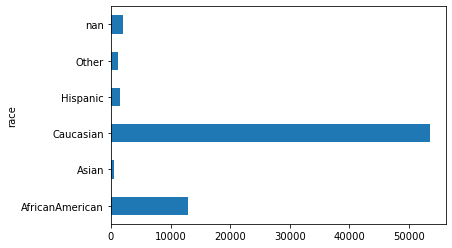

In [102]:
show_group_stats_viz(patient_group_analysis_df, 'race')

race
AfricanAmerican     7719
Asian                282
Caucasian          32082
Hispanic             923
Other                739
nan                 1165
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


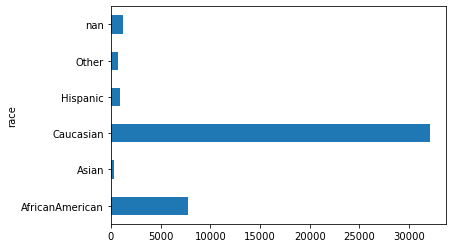

In [103]:
show_group_stats_viz(d_train, 'race')

race
AfricanAmerican     2627
Asian                101
Caucasian          10683
Hispanic             294
Other                209
nan                  390
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


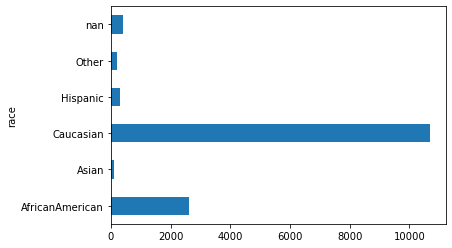

In [104]:
show_group_stats_viz(d_test, 'race')

race
AfricanAmerican     2541
Asian                114
Caucasian          10726
Hispanic             300
Other                230
nan                  393
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


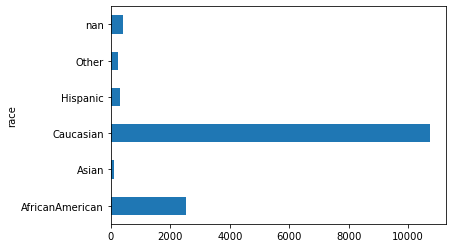

In [105]:
show_group_stats_viz(d_val, 'race')

### Age Group Analysis

age
[0-10)        154
[10-20)       535
[20-30)      1127
[30-40)      2699
[40-50)      6878
[50-60)     12466
[60-70)     15960
[70-80)     18210
[80-90)     11589
[90-100)     1900
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


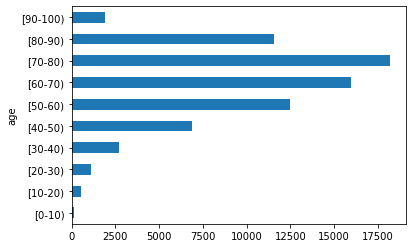

In [106]:
show_group_stats_viz(patient_group_analysis_df, 'age')

age
[0-10)         92
[10-20)       335
[20-30)       700
[30-40)      1570
[40-50)      4146
[50-60)      7498
[60-70)      9595
[70-80)     10893
[80-90)      6964
[90-100)     1117
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


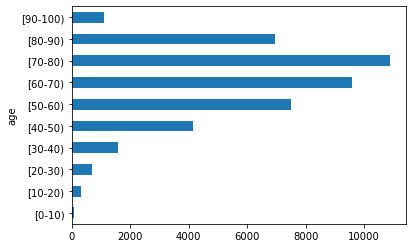

In [107]:
show_group_stats_viz(d_train, 'age')

age
[0-10)        34
[10-20)      103
[20-30)      235
[30-40)      543
[40-50)     1362
[50-60)     2522
[60-70)     3179
[70-80)     3640
[80-90)     2296
[90-100)     390
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


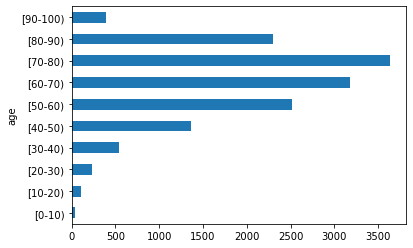

In [108]:
show_group_stats_viz(d_test, 'age')

age
[0-10)        28
[10-20)       97
[20-30)      192
[30-40)      586
[40-50)     1370
[50-60)     2446
[60-70)     3186
[70-80)     3677
[80-90)     2329
[90-100)     393
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


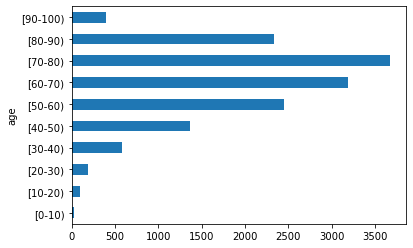

In [109]:
show_group_stats_viz(d_val, 'age')

From the above historgrams, we see that gender, race, and age across our splits have similar distribution shapes across partitions.

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [110]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [111]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [112]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

In [113]:
vocab_file_list

['./diabetes_vocab/primary_diagnosis_code_vocab.txt',
 './diabetes_vocab/readmitted_vocab.txt',
 './diabetes_vocab/A1Cresult_vocab.txt',
 './diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt',
 './diabetes_vocab/Acarbose_vocab.txt',
 './diabetes_vocab/Glimepiride_vocab.txt',
 './diabetes_vocab/Glipizide_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide_vocab.txt',
 './diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Human_Insulin_vocab.txt',
 './diabetes_vocab/Insulin_Human_vocab.txt',
 './diabetes_vocab/Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Miglitol_vocab.txt',
 './diabetes_vocab/Nateglinide_vocab.txt',
 './diabetes_vocab/Pioglitazole_And_Metformin_Hydrochl

In [114]:
vocab_file_list[1]

'./diabetes_vocab/readmitted_vocab.txt'

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [115]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 649 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in A1Cresult is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/A1Cresult_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in Acarbose is inferred from the number of elements in the vo

In [116]:
tf_cat_col_list[2]

IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='A1Cresult', vocabulary_file='./diabetes_vocab/A1Cresult_vocab.txt', vocabulary_size=5, num_oov_buckets=1, dtype=tf.string, default_value=-1))

In [117]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='primary_diagnosis_code', vocabulary_file='./diabetes_vocab/primary_diagnosis_code_vocab.txt', vocabulary_size=649, num_oov_buckets=1, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 650), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [118]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [119]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [120]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [121]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f3a703c10e0>, mean=43.14064320671172, std=19.965743704585915))

tf.Tensor(
[[-0.7368421 ]
 [ 1.4736842 ]
 [-0.7894737 ]
 [-1.1578947 ]
 [-0.7894737 ]
 [-0.8947368 ]
 [-0.15789473]
 [ 0.8947368 ]
 [-0.15789473]
 [-0.21052632]
 [ 0.05263158]
 [ 0.05263158]
 [ 0.36842105]
 [-0.8947368 ]
 [ 0.        ]
 [-1.1578947 ]
 [ 0.31578946]
 [-0.10526316]
 [-0.05263158]
 [-0.5263158 ]
 [-1.9473684 ]
 [-0.31578946]
 [ 0.5263158 ]
 [ 0.36842105]
 [-0.21052632]
 [ 1.4736842 ]
 [-0.15789473]
 [-0.57894737]
 [ 1.4210526 ]
 [ 0.31578946]
 [-0.31578946]
 [-0.5263158 ]
 [-2.2105262 ]
 [ 1.5789474 ]
 [-0.05263158]
 [-1.0526316 ]
 [ 0.31578946]
 [-0.10526316]
 [-1.7368422 ]
 [-0.47368422]
 [ 0.6315789 ]
 [ 1.2105263 ]
 [-0.7368421 ]
 [-0.68421054]
 [ 1.3684211 ]
 [ 0.84210527]
 [-0.5263158 ]
 [ 0.31578946]
 [ 0.105263

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [122]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [123]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [124]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=100)

Train for 336 steps, validate for 112 steps
Epoch 1/100
336/336 [==============================] - 12s 37ms/step - loss: 24.3073 - mse: 24.1285 - val_loss: 18.6947 - val_mse: 18.1902
Epoch 2/100
336/336 [==============================] - 9s 28ms/step - loss: 16.6134 - mse: 15.9894 - val_loss: 13.6382 - val_mse: 12.7889
Epoch 3/100
336/336 [==============================] - 9s 28ms/step - loss: 13.3779 - mse: 12.4476 - val_loss: 12.2278 - val_mse: 11.3542
Epoch 4/100
336/336 [==============================] - 9s 28ms/step - loss: 11.9836 - mse: 10.9941 - val_loss: 10.4821 - val_mse: 9.4831
Epoch 5/100
336/336 [==============================] - 9s 27ms/step - loss: 10.1454 - mse: 9.1753 - val_loss: 10.3971 - val_mse: 9.5026
Epoch 6/100
336/336 [==============================] - 9s 27ms/step - loss: 9.9572 - mse: 9.1244 - val_loss: 9.2412 - val_mse: 8.4833
Epoch 7/100
336/336 [==============================] - 9s 27ms/step - loss: 9.4600 - mse: 8.6865 - val_loss: 9.1633 - val_mse: 8.3786


In [125]:
loss, mse = diabetes_model.evaluate(diabetes_test_ds, verbose=2)

112/112 - 2s - loss: 7.8199 - mse: 6.7463


## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [126]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [127]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [128]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

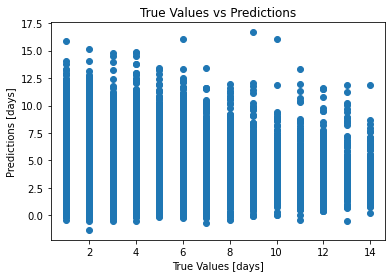

In [129]:
# Plot the True Values vs Predictions
plt.scatter(d_test['time_in_hospital'].values, preds.flatten())
plt.xlabel('True Values [days]')
plt.ylabel('Predictions [days]')
plt.title('True Values vs Predictions')
plt.show()

In [130]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,1.531125,6.0,7.008823,0.689750
1,5.613784,2.0,2.977477,0.690617
2,9.654781,4.0,5.878385,0.690045
3,4.763499,7.0,3.806989,0.690481
4,4.113058,5.0,6.296577,0.689756


In [131]:
prob_output_df.tail()

,pred,actual_value,pred_mean,pred_std
14299,5.210050,5.0,5.343479,0.690064
14300,0.870042,12.0,5.874240,0.689621
14301,3.176161,4.0,6.314635,0.687764
14302,4.789655,1.0,2.977477,0.690617
14303,2.150926,5.0,4.865355,0.690785


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [132]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')
student_binary_prediction

array([1, 0, 1, ..., 1, 0, 0])

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [133]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [134]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,100706733,Female,Caucasian,6.0,1,1
1,16720740,Male,Caucasian,2.0,0,0
2,43564680,Male,Caucasian,4.0,1,0
3,86354838,Female,Caucasian,7.0,0,1
4,92510370,Female,Caucasian,5.0,1,1


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [135]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score 

In [136]:
y_true = pred_test_df['label_value'].values 
y_pred = pred_test_df['score'].values
pred_prob = prob_output_df['pred_mean'].values

In [137]:
print("Classification report: \n",classification_report(y_true, y_pred))
print("Accuracy score: ",accuracy_score(y_true, y_pred))
print("F1 score(weighted): ", f1_score(y_true, y_pred, average='weighted'))

# AUC after we decided our threshold
print("ROC AUC: ",roc_auc_score(y_true, y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.80      0.80      9057
           1       0.66      0.66      0.66      5247

    accuracy                           0.75     14304
   macro avg       0.73      0.73      0.73     14304
weighted avg       0.75      0.75      0.75     14304

Accuracy score:  0.7522371364653244
F1 score(weighted):  0.7523652380193556
ROC AUC:  0.7338378440892706


In [160]:
# Precision and recall unweighted
from sklearn.metrics import precision_score, recall_score
print('Precision: %.3f' % precision_score(y_true, y_pred))
print('Recall: %.3f' % recall_score(y_true, y_pred))

Precision: 0.661
Recall: 0.665


In [138]:
# function to plot the roc_curve. You can utilize roc_curve and auc imported above
def plot_roc_curve(ground_truth, probability):
    fpr, tpr, thresholds = roc_curve(ground_truth, probability)
    AUC = '%s (AUC:%0.2f)'  % ('Time in Hospital', auc(fpr, tpr))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate')
    plt.show()
    print('AUC: ', AUC)
    
# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(ground_truth, probability):
    precision, recall, _ = precision_recall_curve(ground_truth, probability)
    AP = '%s (AP Score:%0.2f)'  % ('Time in Hospital', average_precision_score(ground_truth, probability))
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    print('AP: ', AP) #average_precision_score 

In [161]:
# Function to plot the precision, recall vs threshold
def plot_precision_recall_vs_threshold(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "b--", label="Precision")
    plt.plot(threshold, recall[:-1], "g-", label="Recall")
    plt.legend(["Precision", "Recall"], loc ="center right")
    plt.title('Precision & Recall vs Threshold')
    plt.xlabel('Threshold')
    plt.show

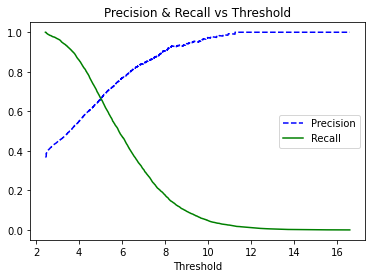

In [162]:
# Let's plot the precision, recall vs threshold to see out choosen threshold is indeed 
# give us the best precision and recall. Also note that we choose threshold >= 5 since we 
# want to predict patients who will stay in the hospital for at least 5 days 

precision, recall, threshold = precision_recall_curve(y_true,pred_prob)

plot_precision_recall_vs_threshold(precision, recall, threshold)

We see that the threshold of 5 is indeed give us the best precision and recall score.

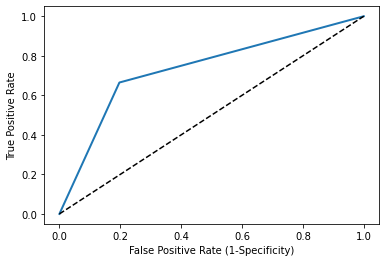

AUC:  Time in Hospital (AUC:0.73)


In [157]:
# AUC after we decided our threshold of time in hospital >= 5
plot_roc_curve(y_true,y_pred)

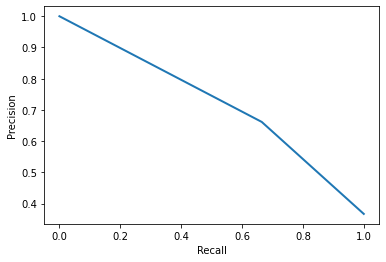

AP:  Time in Hospital (AP Score:0.56)


In [158]:
# Precision_recall curve after we decided our threshold of time in hospital >= 5
plot_precision_recall_curve(y_true,y_pred)

### Summary 

We found that the accuracy of our model is about 0.75, the weighted F1 score is about 0.75, the weighted precision and recall score is about 0.75 each, and ROC AUC is about 0.73 when we chose the threshold >= 5. 

Precision or positive predictive value is the proportion of positive cases accurately identified by the algorithm over all cases identified as positive by the algorithm (TP/(TP + FP)). On the other hand, recall or true positive rate or sometimes called sensitivity is the proportion of all positive cases accurately identified by the algorithm over all positive cases in the dataset (TP/(TP+FN)). A high precision test gives us more confidence that a positive test result is actually positive since a high presision test has low false positive. On the other hand, with a high recall test, we can be confident that the result is truly negative since a high recall test has low false negaive. Precision does not take FN into account while recall does not take FP into account. Most of the time, if the precision increases, recall decreases and vice versa. For binary classification problem, F1 score is the harmonic mean of precision and recall which formula is 2*(precision * recall)/(precision + recall). 

Ussually, we prefer high F1 score with high precision and recall score. However, our Expected Hospitalization Time Regression Model is only used to predict the lenght of stay in the hospital so we can administer the groundbreaking diabetes drug over at least 5-7 days. Therefore, probably we should weight precision a little more than recall since with higher precision we can have higher confidence in positive result or confirming that the patient will be hospitalized for at least 5 days so we can administer our diabetes drug. In our case, we won't suffer a dire consequence if we don't administer our drug to patient who we mistakenly assume wom't stay in the hospital for at least 5 days.

From the precision, recall vs threshold plot, we see that threshold equal to 5 will give us a balance precision and recall of 0.66 each or 0.75 each for the weighted score. From the previous rationale, it seems that it is ok to sacrifice the recall a little in order to gain a higher precision. If we want a higher precision, we can increase the threshold a little to 6 or 7. But we must be careful not to increase our threshold so it is greater than 7 since it will decrease our recall considerably and cause us lose a lot of potential patients for our drug testing. 

To improve our model, we can try a number of things such as:
* Try different neural net architectures
* Try different optimizers
* Try different learning rates
* Use regularization to avoid overfitting

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [141]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [5273]}


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [142]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [143]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,AfricanAmerican,0.68,0.77,0.20,0.35,0.23,0.32,0.80,0.65,0.20,0.40,0.38
1,race,Asian,0.60,0.85,0.20,0.32,0.15,0.40,0.80,0.68,0.01,0.31,0.35
2,race,Caucasian,0.66,0.81,0.20,0.34,0.19,0.34,0.80,0.66,0.73,0.36,0.37
3,race,Hispanic,0.68,0.83,0.15,0.35,0.17,0.32,0.85,0.65,0.02,0.33,0.31
4,race,Other,0.69,0.80,0.17,0.35,0.20,0.31,0.83,0.65,0.01,0.37,0.34
5,race,nan,0.69,0.83,0.18,0.29,0.17,0.31,0.82,0.71,0.03,0.36,0.37
6,gender,Female,0.67,0.79,0.20,0.35,0.21,0.33,0.80,0.65,0.56,0.38,0.37
7,gender,Male,0.66,0.82,0.19,0.33,0.18,0.34,0.81,0.67,0.44,0.35,0.36


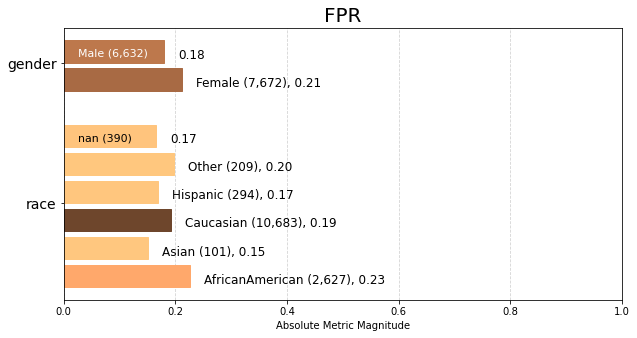

In [145]:
frp = aqp.plot_group_metric(xtab, 'fpr')

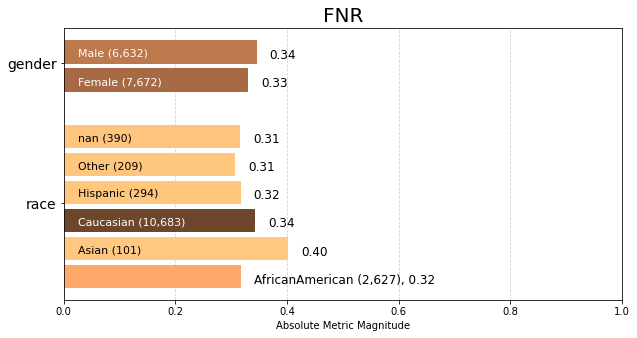

In [146]:
fnr = aqp.plot_group_metric(xtab, 'fnr')

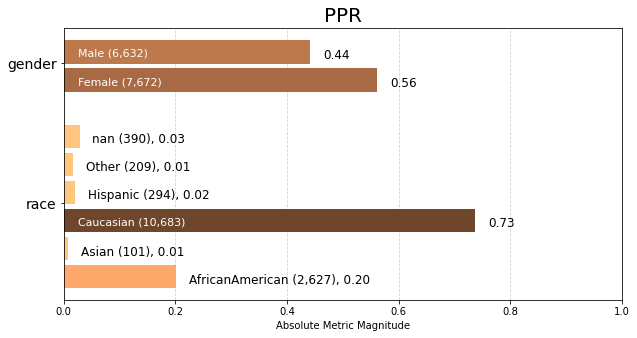

In [147]:
ppr = aqp.plot_group_metric(xtab, 'ppr')

From the visualizations above, we can see that the bias or disparity of the group metrics False Positive Rate (FPR), False Negative Rate (FNR), and Positive Predictive Rate (PPR) across gender is very small or insignificant. However, we can see a significant bias of the group metrics PPR across race. Here, we see that Caucasian has a PPR score of 0.73 followed by African American which has a PPR score of 0.20. This means our model correctly predict most Caucasian which are hospitalized for at least 5 days as the ones who really stay in the hospital for at least 5 days. On the other hand, Hispanic, Asian, and Other race have a PPR of less than or equal to 0.03. This means our model incorectly predict the lenght of hospital stay for these race most of the times.

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

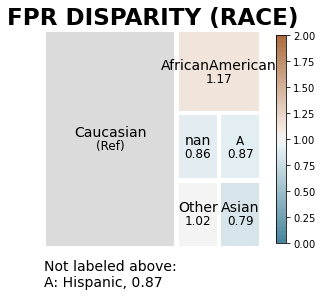

In [148]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='race')

African American is 1.17x more likely to be falsely identified than Caucasian. On the other hand, Asian is 0.79x more likely to be falsely identified.

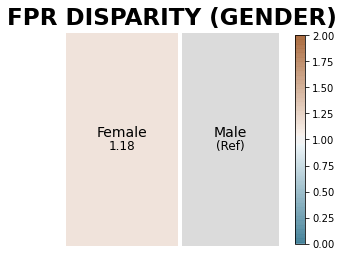

In [149]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='gender')

Female is 1.18x more likely to be falsely identified than Male.

### Absolute Value Fairness Determination
- Red = False/Not Fair
- Green = True/Fair

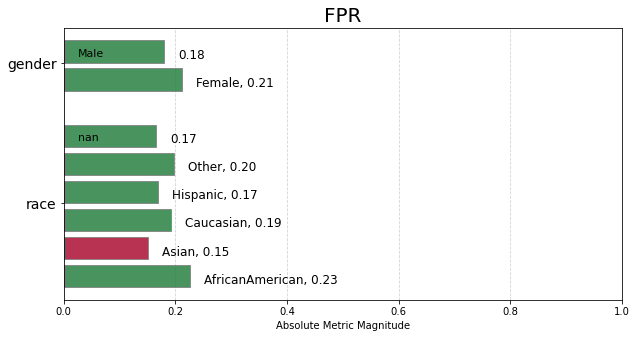

In [150]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

From the absolute group metric False Positive Rate (FPR) across gender and race. We see that the Asian is likely to be unfairly predicted by our model with lower false positive rate. This means our model is less likely to predict Asian which actually s 

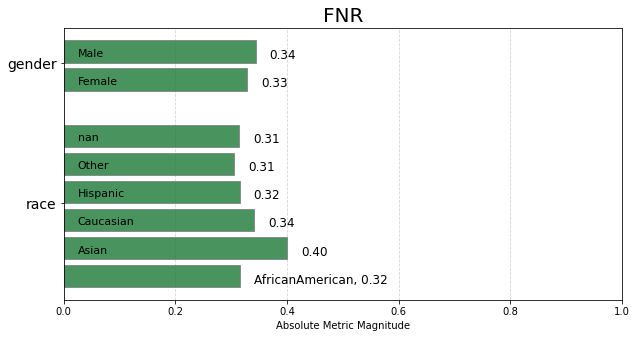

In [151]:
fnr_fairness = aqp.plot_fairness_group(fdf, group_metric='fnr', title=True)

The chart of absolute group metric False Negative Rate (FNR) across gender and race shows that our model is fair across all groups.

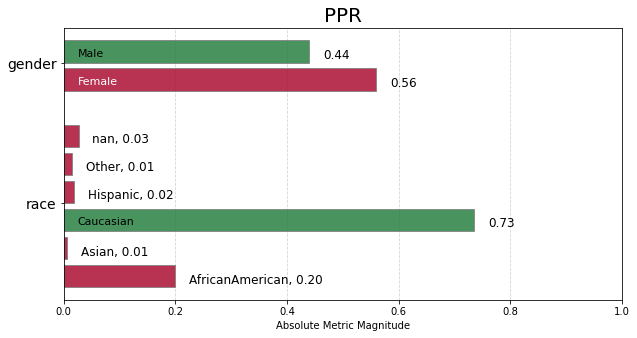

In [152]:
ppr_fairness = aqp.plot_fairness_group(fdf, group_metric='ppr', title=True)

The chart above displays absolute group metric Positive Predictive Rate (PPR) across gender and race. We can see that from the green color that only Male and Caucasian groups have been determined to be fair. On the other hand. Female, African American, Asian, Hispanic, other race are unfairly predicted by our model by having lower PPR.